In [27]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import pandas as pd
import os

class SpeciesDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.root_dir, row['species'], row['imageFile'])
        image = Image.open(img_path).convert('RGB')
        label = row['species_id']
        if self.transform:
            image = self.transform(image)
        return image, label


In [28]:
from torch.utils.data import DataLoader
from torchvision import transforms

# Common transform pipeline (can be customized further)
common_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Datasets
train_dataset = SpeciesDataset("/Users/mdshayan/Desktop/invasive-species-classifier/data/splits/train.csv", "/Users/mdshayan/Desktop/invasive-species-classifier/data/preprocessed", transform=common_transform)
val_dataset   = SpeciesDataset("/Users/mdshayan/Desktop/invasive-species-classifier/data/splits/val.csv", "/Users/mdshayan/Desktop/invasive-species-classifier/data/preprocessed", transform=common_transform)
test_dataset  = SpeciesDataset("/Users/mdshayan/Desktop/invasive-species-classifier/data/splits/test.csv", "/Users/mdshayan/Desktop/invasive-species-classifier/data/preprocessed", transform=common_transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)


In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")


Using device: mps


In [30]:
from torchvision import models

def get_model(model_name: str, num_classes: int):
    if model_name == "resnet18":
        model = models.resnet18(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)

    elif model_name == "mobilenet_v2":
        model = models.mobilenet_v2(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

    elif model_name == "efficientnet_b0":
        model = models.efficientnet_b0(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

    else:
        raise ValueError(f"Unknown model name: {model_name}")
    
    return model.to(device)


In [31]:
#Training the model
def train_model(model, train_loader, val_loader, num_epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {total_loss:.4f}")


In [32]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(model, test_loader, num_classes):
    model.eval()
    all_preds, all_labels, all_probs = [], [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            preds = np.argmax(probs, axis=1)

            all_preds.extend(preds)
            all_labels.extend(labels.numpy())
            all_probs.extend(probs)

    # Metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average="macro")
    recall = recall_score(all_labels, all_preds, average="macro")
    f1 = f1_score(all_labels, all_preds, average="macro")
    
    try:
        auc = roc_auc_score(all_labels, all_probs, multi_class='ovr')
    except:
        auc = float('nan')  # AUC fails if only 1 class in preds
    
    print("\n📊 Classification Report:\n")
    print(classification_report(all_labels, all_preds, zero_division=0))

    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"AUC:       {auc:.4f}")

    return all_labels, all_preds


In [33]:
#Confusion metrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()


/Users/mdshayan/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mdshayan/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/5] Loss: 140.1719
Epoch [2/5] Loss: 85.0657
Epoch [3/5] Loss: 59.4848
Epoch [4/5] Loss: 47.0302
Epoch [5/5] Loss: 42.6993

📊 Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3708
           1       0.98      0.98      0.98      3224

    accuracy                           0.98      6932
   macro avg       0.98      0.98      0.98      6932
weighted avg       0.98      0.98      0.98      6932

Accuracy:  0.9824
Precision: 0.9823
Recall:    0.9824
F1 Score:  0.9823
AUC:       nan


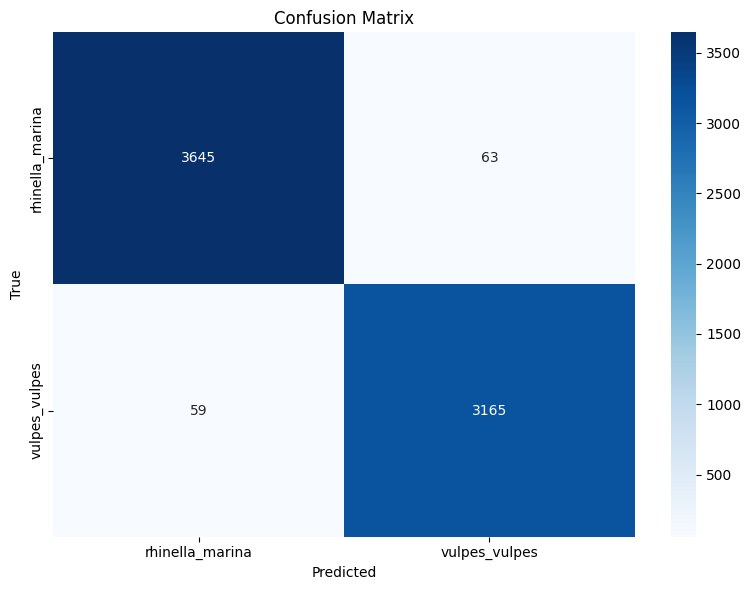

In [26]:
# Assume already loaded:
# train_loader, val_loader, test_loader

# Load label mapping from metadata_labels CSV
label_csv = pd.read_csv("/Users/mdshayan/Desktop/invasive-species-classifier/data/metadata_labels/image_labels.csv")

# Create mapping from species name to numeric label
label_mapping = label_csv[['species', 'species_id']].drop_duplicates().set_index('species')['species_id'].to_dict()
class_names = list(label_mapping.keys())


num_classes = len(label_mapping)
class_names = list(label_mapping.keys())

model = get_model(num_classes)
train_model(model, train_loader, val_loader, num_epochs=5)

y_true, y_pred = evaluate_model(model, test_loader, num_classes)
plot_confusion_matrix(y_true, y_pred, class_names)


In [34]:
# Load label mapping from metadata_labels CSV
label_csv = pd.read_csv("/Users/mdshayan/Desktop/invasive-species-classifier/data/metadata_labels/image_labels.csv")

# Create mapping from species name to numeric label
label_mapping = label_csv[['species', 'species_id']].drop_duplicates().set_index('species')['species_id'].to_dict()
class_names = list(label_mapping.keys())


num_classes = len(label_mapping)
class_names = list(label_mapping.keys())

/Users/mdshayan/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mdshayan/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /Users/mdshayan/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:01<00:00, 12.9MB/s]


Epoch [1/5] Loss: 136.5037
Epoch [2/5] Loss: 79.6158
Epoch [3/5] Loss: 58.9460
Epoch [4/5] Loss: 50.3926
Epoch [5/5] Loss: 38.7343

📊 Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      3708
           1       0.98      0.98      0.98      3224

    accuracy                           0.98      6932
   macro avg       0.98      0.98      0.98      6932
weighted avg       0.98      0.98      0.98      6932

Accuracy:  0.9830
Precision: 0.9830
Recall:    0.9828
F1 Score:  0.9829
AUC:       nan


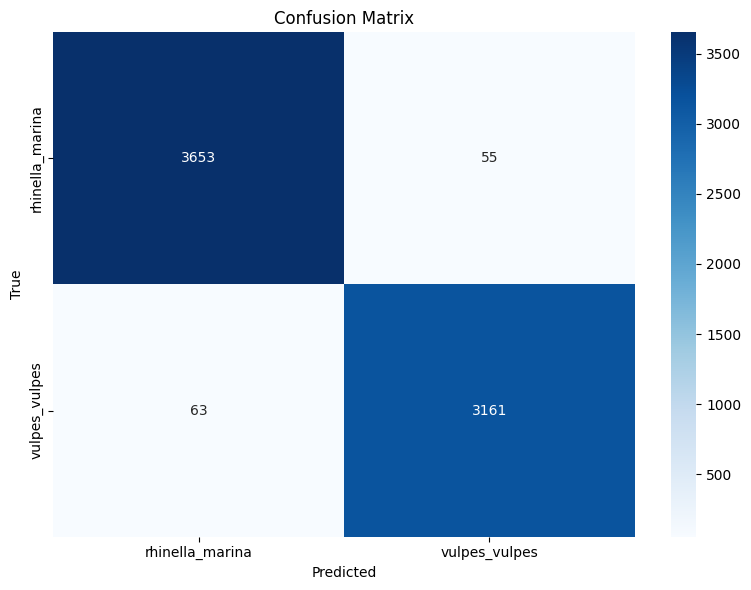

In [35]:
# Options: "resnet18", "mobilenet_v2", "efficientnet_b0"
model_name = "mobilenet_v2"  # or "efficientnet_b0", "resnet18"
model = get_model(model_name, num_classes)

# Train and evaluate as before
train_model(model, train_loader, val_loader, num_epochs=5)
y_true, y_pred = evaluate_model(model, test_loader, num_classes)
plot_confusion_matrix(y_true, y_pred, class_names)


/Users/mdshayan/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mdshayan/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /Users/mdshayan/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:01<00:00, 17.4MB/s]


Epoch [1/5] Loss: 133.4446
Epoch [2/5] Loss: 59.4674
Epoch [3/5] Loss: 36.8989
Epoch [4/5] Loss: 24.7980
Epoch [5/5] Loss: 19.5382

📊 Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3708
           1       0.99      0.99      0.99      3224

    accuracy                           0.99      6932
   macro avg       0.99      0.99      0.99      6932
weighted avg       0.99      0.99      0.99      6932

Accuracy:  0.9911
Precision: 0.9908
Recall:    0.9913
F1 Score:  0.9910
AUC:       nan


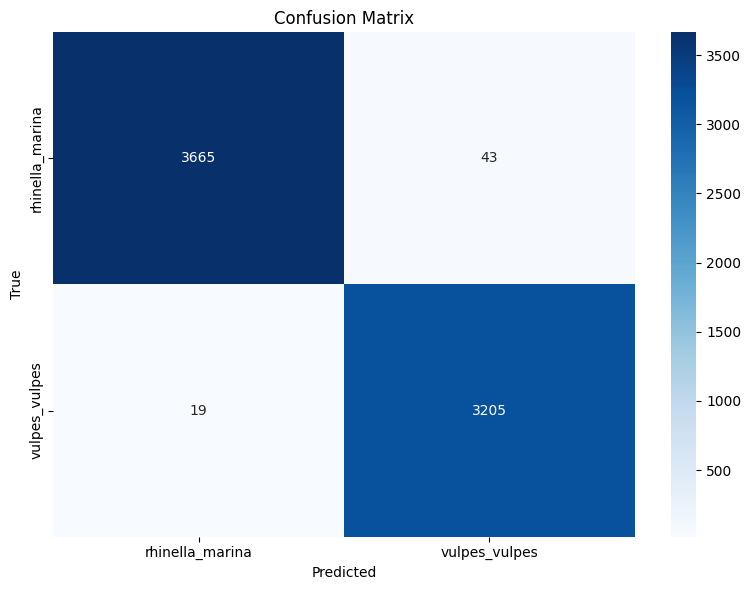

In [36]:
# Options: "resnet18", "mobilenet_v2", "efficientnet_b0"
model_name = "efficientnet_b0"  # or "efficientnet_b0", "resnet18"
model = get_model(model_name, num_classes)

# Train and evaluate as before
train_model(model, train_loader, val_loader, num_epochs=5)
y_true, y_pred = evaluate_model(model, test_loader, num_classes)
plot_confusion_matrix(y_true, y_pred, class_names)
